In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _canoeValues as cv
import math

#-------------------Inputs-------------------------------------------------------------
script = "Longitudinal Analysis_2 Paddler.ipynb"
input_file = "Station Information.csv"
outerHull_file = "Outer Hull.csv" # Will be used for hydrostatic force and waterline calculation
DLF = cv.DLF # Dead Load Factor
LLF = 1.3 # Live Load Factor
pad_weights = cv.pad_weights # Weight of paddlers (kg)
water_den = cv.water_density # Density of water = 1000 kg/m^3
#--------------------------------------------------------------------------------------
# Acquire the waterline from Grasshopper
grasshopper = cv.grasshopper[0] # [mm]

pad1_pos = 1710 # Position of first paddler with respect to left end of canoe (mm)
pad2_pos = 4100 # Position of second paddler with respect to left end of canoe (mm)
# Choose between pad_weights
pad_first = pad_weights[3]
pad_second = pad_weights[2]
# Apply the Live Load Factor (constsant)
pad1 = pad_first * LLF
pad2 = pad_second * LLF
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('data') # absolute file path in Jupyter
file_path = os.path.join(script_dir, input_file) # file path for the station information

# Get the canoe's volume and mass from the station info
canoe_info = pd.read_csv(file_path, header=None)
statVol = canoe_info[1][1:]
statMass = canoe_info[2]

# Get the outer hull coordinates from the input file
file_path = os.path.join(script_dir, outerHull_file)
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

# Get the mass and volume at each station from the Station Information csv file (exported from Approximation-Vol Diff)
stat_Mass = []
for i in range(1,len(statMass),1):
    stat_Mass.append(float(statMass[i]))
    
stat_Vol = []
for i in range(1,len(statVol),1):
    stat_Vol.append(float(statVol[i]))

canoe_volume = np.sum(stat_Vol) # m^3
canoe_mass = np.sum(stat_Mass)*DLF # [kg]
total_mass = canoe_mass + pad1 + pad2 # [kg]

station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

In [2]:
# Calculate Centre of Mass
stations_mm = [x * float(canoe_info[4][1]) for x in range(0,station_no-1)]

mass_sum = 0
for i in range(len(station)-1):
    mass_sum += stat_Mass[i] * stations_mm[i]
    
mass_sum += pad1 * pad1_pos + pad2 * pad2_pos

centre_of_mass = mass_sum / (sum(stat_Mass) + pad1 + pad2)

print(centre_of_mass) # mm

2809.12518998392


In [3]:
# Outer Hull Volume
vol_out = []

# Loop through each station
# The loop ends at station_no - 2 because each loop uses the kth and the (k+1)th station
# Starts at 1 to skip 0,0,0
for k in range(1,station_no-2,1):

    # Coordinates of points in the outer frame sharing an X-coordinate with the current station
    X1_value = station[k]
    Y1 = []
    Z1 = []

    # Coordinates of points in the outer frame sharing an X-coordinate with the next station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each x coordinate in the outer hull
    for i in range(0,len(x_out),1):

        # If the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])

        # Otherwise, if the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    
    
    volume = 0
    if len(Y1) > 0:
        n = (len(Y1)-1)//2
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n] - Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n] - Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)

outer_volume = np.sum(vol_out)/10**9 #[m^3]

In [4]:
canoe_depth = max(abs(z_out)) 

# Measured from bottom
waterline_ptr_low = 0
waterline_ptr_high = canoe_depth-1

increment = 3 # push down waterline by [] mm
water_weight = outer_volume * water_den # Assume canoe is fully submerged in water

angle = 0

# Get waterline
# While True
#   get angle s.t. moment = 0
#   check if waterline is good
#       true -> break
#       false -> adjust waterline

def calcWaterMassDisplaced(waterline, angle):
    
    waterline_slope = math.tan(math.radians(angle))
    stat_waterline = []
    
    for x in station:
        waterline_at_station = (x - centre_of_mass) * waterline_slope + waterline
        if waterline_at_station > canoe_depth:
            raise Exception("The canoe takes on water!")
        stat_waterline.append(waterline_at_station)
    
    # Loop until waterline is balanced
    while True:
        
        #region Calculate Water Volume Displaced
        
        #while water_weight - total_weight > 10:
        vol_out = []
        for k in range(0,station_no-1):
            
            # Station k coordinates (x,y,z)
            X1_value = station[k]
            Y1 = []
            Z1 = []
            
            # Station k+1 coordinates (x,y,z)
            X2_value = station[k+1]
            Y2 = []
            Z2 = []
            
            Y1_interp = []
            Y2_interp = []
            
            #For all outer hull x-coordinates, if the x-coordinate is equal to the x-coordinates of the kth and k+1 stations, store the x, y, and z coordinates of that outer hull coordinate
            for i in range(0,len(x_out),1):
                # Get the points under the waterline
                if x_out[i] == X1_value:
                    if canoe_depth - abs(z_out[i]) <= stat_waterline[k]:
                        Y1.append(y_out[i])
                        Z1.append(z_out[i])
                        
                        if canoe_depth - abs(z_out[i-1]) > stat_waterline[k]:

                            yInterpPoint = y_out[i-1] + ((y_out[i]-y_out[i-1]) / (z_out[i] - z_out[i-1])) * (stat_waterline[k] - canoe_depth - z_out[i-1])
                            
                            Y1_interp.append(yInterpPoint)
                                    
                        if canoe_depth - abs(z_out[i+1]) > stat_waterline[k]:
                            
                            yInterpPoint = y_out[i] + ((y_out[i+1]-y_out[i]) / (z_out[i+1] - z_out[i])) * (stat_waterline[k] - canoe_depth - z_out[i])
                            
                            Y1_interp.append(yInterpPoint)

                elif x_out[i] == X2_value:
                    if canoe_depth - abs(z_out[i]) <= stat_waterline[k+1]:
                        Y2.append(y_out[i])
                        Z2.append(z_out[i])
                        
                        if canoe_depth - abs(z_out[i-1]) > stat_waterline[k+1]:

                            yInterpPoint = y_out[i-1] + ((y_out[i]-y_out[i-1]) / (z_out[i] - z_out[i-1])) * (stat_waterline[k+1] - canoe_depth - z_out[i-1])
                            
                            Y2_interp.append(yInterpPoint)
                                    
                        if canoe_depth - abs(z_out[i+1]) > stat_waterline[k+1]:
                            
                            yInterpPoint = y_out[i] + ((y_out[i+1]-y_out[i]) / (z_out[i+1] - z_out[i])) * (stat_waterline[k+1] - canoe_depth - z_out[i])
                            
                            Y2_interp.append(yInterpPoint)
                
            if len(Y1) == 0 and len(Y2) == 0:
                # Station is out of the water
                vol_out.append(0)
                continue
            elif len(Y1) == 0 or len(Y2) == 0:
                # Interpolate the waterline for the submerged station
                if len(Y1) == 0:
                    Y2 = [Y2_interp[0]] + Y2 + [Y2_interp[-1]]
                    Z2 = [stat_waterline[k+1] - canoe_depth] + Z2 + [stat_waterline[k+1] - canoe_depth]
                    
                    Y1 = [0]
                    Z1 = [stat_waterline[k]]
                else:
                    Y1 = [Y1_interp[0]] + Y1 + [Y1_interp[-1]]
                    Z1 = [stat_waterline[k] - canoe_depth] + Z1 + [stat_waterline[k] - canoe_depth]
                    
                    Y2 = [0]
                    Z2 = [stat_waterline[k+1]]
            else:
                Y1 = [Y1_interp[0]] + Y1 + [Y1_interp[-1]]
                Y2 = [Y2_interp[0]] + Y2 + [Y2_interp[-1]]
                
                Z1 = [stat_waterline[k] - canoe_depth] + Z1 + [stat_waterline[k] - canoe_depth]
                Z2 = [stat_waterline[k+1] - canoe_depth] + Z2 + [stat_waterline[k+1] - canoe_depth]

            volume = 0
            #If outer hull x-coordinates that matched the station x-coordinates were found, then the volume of water will be calculated using the formulae below (this takes the area between the coordinates to calculate volume)
            if len(Y1) > 0:
                
                # Add points at the waterline to ensure both stations have THE SAME NUMBER OF POINTS below the waterline
                # This is necessary to ensure we are calculating the volume of the correct shape (points are not misaligned)
                while len(Y1) < len(Y2):
                    Y1 = [Y1[0]] + Y1 + [Y1[-1]]
                    Z1 = [Z1[0]] + Z1 + [Z1[-1]]
                while len(Y2) < len(Y1):
                    Y2 = [Y2[0]] + Y2 + [Y2[-1]]
                    Z2 = [Z2[0]] + Z2 + [Z2[-1]]
                
                # Loop through half the points (done in order to calculate area as a trapezoid)
                n = (len(Y1)-1)//2
                for j in range(0,n,1):
                    area1 = ((abs(Y1[j])+abs(Y1[j+1]))/2 * abs(Z1[j]-Z1[j+1])) * 2
                    area2 = ((abs(Y2[j])+abs(Y2[j+1]))/2 * abs(Z2[j]-Z2[j+1])) * 2
                    volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
                # triangle piece at the bottom
                area1 = abs(Y1[n-1])*abs(Z1[n] - Z1[n-1])/2*2
                area2 = abs(Y2[n-1])*abs(Z2[n] - Z2[n-1])/2*2
                volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
                vol_out.append(volume)

        #endregion
        
        #Combines the calculated water volumes above into a total water volume
        displaced_water_volume = np.sum(vol_out)/10**9 #[m^3]
        
        #Water mass = water volume (above) multiplied by the water denisty (constant defined at the start of the program. It can be changed on line 15)
        displaced_water_mass = displaced_water_volume * water_den
        
        return [vol_out, displaced_water_mass]

# Loop to calculate angle of canoe at rest in water
# Loop until moment at the end of the canoe is equal to zero
while True:
    
    # Find Waterline
    waterline = -1
    
    print(f"Solving Waterline for Angle={angle}")
    print("Estimate | Error")
    # Loop until we find the waterline
    while True:
        
        vol_out_low, water_mass_displaced_low = calcWaterMassDisplaced(waterline_ptr_low, angle)
        vol_out_mid, water_mass_displaced_mid = calcWaterMassDisplaced((waterline_ptr_low + waterline_ptr_high)/2, angle)
        vol_out_high, water_mass_displaced_high = calcWaterMassDisplaced(waterline_ptr_high, angle)
        
        difference_low = water_mass_displaced_low - total_mass
        difference_mid = water_mass_displaced_mid - total_mass
        difference_high = water_mass_displaced_high - total_mass
        
        if abs(difference_low) < 0.01:
            waterline = waterline_ptr_low
            vol_out = vol_out_low
            break
        
        if abs(difference_mid) < 0.01:
            waterline = (waterline_ptr_low + waterline_ptr_high)/2
            vol_out = vol_out_mid
            break
        
        if abs(difference_high) < 0.01:
            waterline = waterline_ptr_high
            vol_out = vol_out_high
            break
    
        # Interpolate to find estimated location of waterline
        estimate = waterline_ptr_low + (waterline_ptr_high-waterline_ptr_low) * (abs(difference_low) / (abs(difference_low) + abs(difference_high)))
        
        error = (abs(difference_low) + abs(difference_high)) / 10
        
        print(f"{estimate} | {error}")
        
        waterline_ptr_low = estimate - error
        waterline_ptr_high = estimate + error
        
    print("Solved waterline: ", waterline)

    #region Calculate Shear Force
    mass_out = []
    for i in range(0,len(vol_out),1):
        mass = (vol_out[i]/10**9) * water_den
        mass_out.append(mass)
    
    pad_weight = [pad1, pad2]

    length = max(x_out)
    pad_pos = [pad1_pos, pad2_pos]

    # Make an array containing the middle x-coordinate of each station
    stat_x = []
    for i in range(0,len(station)-1,1):
        stat_x.append((station[i]+station[i+1])/2)

    # Calculate the shear force
    g = 9.81
    x = []
    shear = []
    # Loop through the length of the canoe
    for i in range(0,int(length),1):
        # Append the current distance travelled along the length of the canoe onto x
        x.append(i)

        # Calculate the shear force for this station
        shear_force = 0

        # Loop through each station
        for j in range(0,len(stat_x),1):
            # For each station we have moved past along the length of the canoe, sum up their impact on the shear force
            if i >= stat_x[j]:
                shear_force += mass_out[j]*g +(-1)*stat_Mass[j]*g*DLF
        
        # Loop through each paddler
        for k in range(0,len(pad_pos),1):
            # For each station we have moved past along the length of the canoe, subtract their weight from the shear force calculation
            if i >= pad_pos[k]:
                shear_force = shear_force - pad_weight[k]*g

        # Append the shear force summed at this length along the canoe
        shear.append(shear_force)
    
    #endregion
     
    moment = [0]
    bending_moment = 0
    
    #Calculates the new bending moment using shear
    for i in range(1,len(x),1):
        bending_moment = bending_moment + (x[i]-x[i-1])*shear[i]/1000
        moment.append(bending_moment)
        
    print("New Moment:", moment[-1])

    # Exit the loop if we have balanced out our bending moment
    if abs(moment[-1]) < 0.01:
        break
    # Otherwise, move the angle to correct it and repeat
    else:
        angle += moment[-1]/1000
        waterline_ptr_low -= abs(moment[-1])/10
        waterline_ptr_high += abs(moment[-1])/10

print('The depth of water is ', waterline, ' mm.')
print('The waterline is at', canoe_depth-waterline, 'mm.')
print('The weight of water is ', water_weight, 'kg.')
print('The total weight is ', total_mass, 'kg.')
print('The angle of the canoe is ', angle)

Solving Waterline for Angle=0
Estimate | Error
145.00564224064692 | 85.84303827250517
180.73461210974594 | 36.04719657901115
182.7981640979813 | 15.67005751341859
183.1398686898414 | 6.829725465215693
183.20031001746483 | 2.977866540440698
183.21194378018987 | 1.2985061176163697
Solved waterline:  183.21194378018987
New Moment: -0.5293001799745951
Solving Waterline for Angle=-0.0005293001799745951
Estimate | Error
Solved waterline:  183.21194378018987
New Moment: -0.21987864432542137
Solving Waterline for Angle=-0.0007491788243000166
Estimate | Error
Solved waterline:  183.21194378018987
New Moment: -0.09133893584398753
Solving Waterline for Angle=-0.0008405177601440041
Estimate | Error
Solved waterline:  183.21194378018987
New Moment: -0.03794245908772333
Solving Waterline for Angle=-0.0008784602192317275
Estimate | Error
Solved waterline:  183.21194378018987
New Moment: -0.01576135684268321
Solving Waterline for Angle=-0.0008942215760744107
Estimate | Error
Solved waterline:  183.211

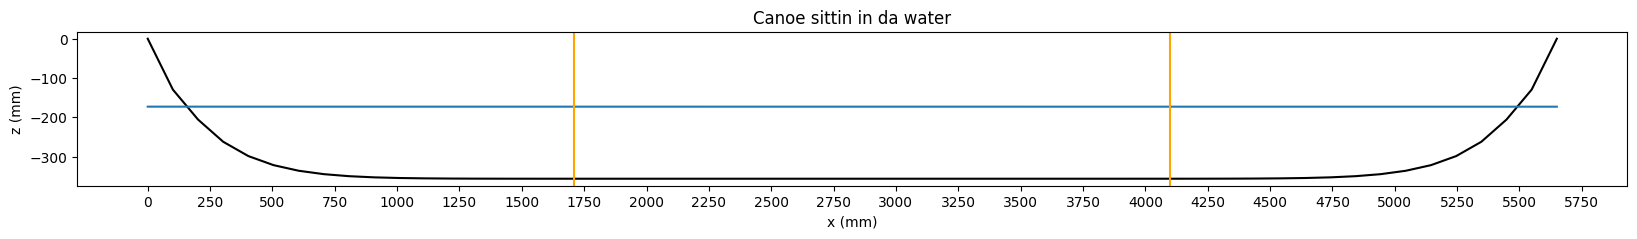

In [5]:
# Canoe Points
plotOuterHull = []
for k in range(station_no):
    plotOuterHull.append(0)
    for i in range(0,len(x_out),1):
        if x_out[i] == station[k]:
            if z_out[i] < plotOuterHull[k]:
                plotOuterHull[k] = z_out[i]

# Waterline
slope = math.tan(math.radians(angle))
yint = -centre_of_mass * slope + waterline          

# Plot lenthwise
plt.figure(figsize=(20, 2))
plt.plot(station, plotOuterHull, c='black')
plt.plot(station, (slope * station + yint) - canoe_depth)
plt.axvline(pad1_pos, c='orange')
plt.axvline(pad2_pos, c='orange')
plt.xticks(range(0, 6000, 250))
plt.title(f'Canoe sittin in da water')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.show()

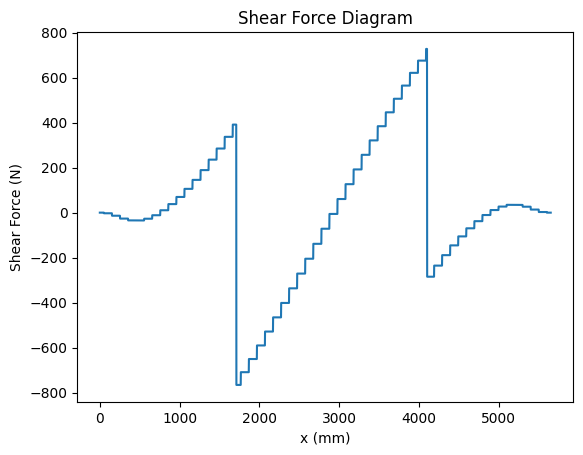

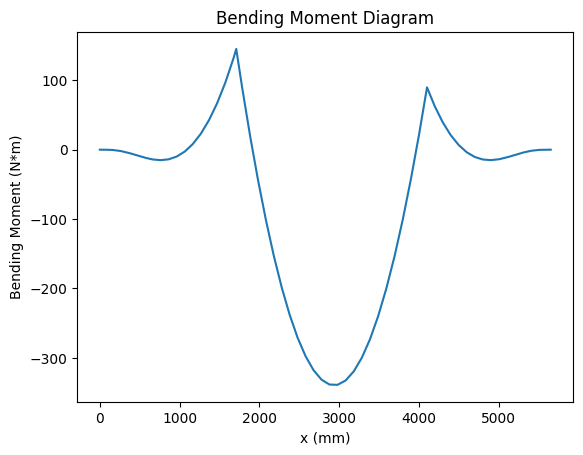

Maximum shear is  765.6457664519504 N.
Maximum moment is  339.00870201307396 Nm.
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.8144134788130843, -2.814413

In [6]:
plt.plot(x,shear)
plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (N)')
plt.show()

# Track mm distance of station for paddler positions
mm_traveled = 0
paddler_counter = 0

# Store Vf and paddlers? for csv file
Paddler_array = []
Station_by_length = []

for i in range(1, len(station)):

    # Check if a paddler is in this station and calculate the new distance travelled accordingly
    stationHasPaddler = False
    
    delta_mm_traveled = mm_traveled + float(canoe_info[4][i])

    # Any distance between the distance travlled (rounded) and the new distance travelled (larger due to more paddlers) (also rounded) will be saved. Anything else is discarded
    for j in range(round(mm_traveled), round(delta_mm_traveled)):
        Station_by_length.append(i)

    if(paddler_counter < len(pad_pos)) and (mm_traveled <= pad_pos[paddler_counter] and delta_mm_traveled > pad_pos[paddler_counter]):
        stationHasPaddler = True
        paddler_counter += 1
    mm_traveled = delta_mm_traveled

    Paddler_array.append(stationHasPaddler)

# Export points to csv file (only calculates new bending moment -> outlined below):
df1 = pd.DataFrame(data={'Station': Station_by_length, 'Length': x, 'Shear': shear})

csv_file = 'Length_vs_Shear_2 Paddler.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)

plt.plot(x,moment)
# plt.axhline(0, c='orange')
plt.title('Bending Moment Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Bending Moment (N*m)')
plt.show()


# Export points to csv file (only calculates maximum shear and moments -> outlined below):
df1 = pd.DataFrame(data={'Station': Station_by_length, 'Length': x, 'Moment': moment})

csv_file = 'Length_vs_Moment_2 Paddler.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)


#Calculates the maximum shear and maximum moments 
max_shear = max(abs(min(shear)), abs(max(shear)))
max_moment = max(abs(min(moment)), abs(max(moment)))

print('Maximum shear is ', max_shear, 'N.')
print('Maximum moment is ', max_moment, 'Nm.')
print(shear)

In [7]:
# READ ME BEFORE SCROLLING: export the values to csv file (This code has nothing to do with calculations, it only saves values so it can be ignored from a calculation standpoint)
titles = ['Positive Shear [N]', 'Negative Shear [N]', 'Positive Bending Moment [Nm]', 'Negative Bending Moment [Nm]', 'Moment at the end [Nm]']
values = [max(shear), min(shear), max(moment), min(moment), moment[len(moment)-1]]
station_no = []
max_width = []
max_depth = []

for value in [max(shear), min(shear)]:
    shear_index = shear.index(value)
    xshear = x[shear_index]
    for i in range(0,len(station)-1,1):
        if (xshear >= station[i] and xshear < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)

for value in [max(moment), min(moment)]:
    moment_index = moment.index(value)
    xmoment = x[moment_index]
    for i in range(0,len(station)-1,1):
        if (xmoment >= station[i] and xmoment < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    
station_no.append(len(station)-1)  
max_width.append('')
max_depth.append('')

df1 = pd.DataFrame(data={'': titles, 'Value': values, 'Station No': station_no, 'Max Width [mm]': max_width, 'Max Depth [mm]': max_depth})

csv_file = 'Shear_and_Moment_2 Paddlers.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)


In [8]:
# Make a CSV file for buoyancy and gravity
# vol_mass (Array of force_buoyancy by station)
# stat_mass (Array of force_gravity by station)
df1 = pd.DataFrame(data={'Station No.': range(1, len(vol_mass) + 1, 1), 'Buoyancy Force [N]': [i * g for i in vol_mass], 'Self Weight': [i * g for i in stat_Mass], 'Has Paddler?': Paddler_array})

csv_file = 'Station_Loads_2 Paddlers.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)
print("Complete !")

NameError: name 'vol_mass' is not defined

# 

In [ ]:
# This will be the script for deflection calculation
# Currently not implemented

# Convert x to m
x = [i / 1000 for i in x]

# TAKE I FROM FLEXURAL STRESS
# Take e as an input?
# <?> DIVIDE BENDING MOMENT BY EI
moment_ei = [j / (e * I[j]) for j in moment]

# Integrate a matplotlib graph
# xList and yList are from matplotlib graph
# C is the integration constant
def integrate(yList, xList, C):
    # The function starts at C
    output = [C]
    for i in range(len(xList) - 1):
        riemannHeight = yList[i+1] + yList[i] / 2
        riemannWidth = xList[i+1] - xList[i]
        output.append(output[i] + (riemannHeight * riemannWidth))
    return output


# Integrate to find slope
slope = integrate(moment, x, 0)

# Plot slope
plt.plot(x,slope)
plt.title("Slope (Bending Moment Once Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Slope (N*m^2)')
plt.show()

# Integrate to find deflection
deflection = integrate(slope, x, 0)

# Plot Deflection
plt.plot(x,deflection)
plt.title("Deflection (Bending Moment Twice Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Deflection (N*m^3)')
plt.show()


NameError: name 'e' is not defined